# Credit Card Approval Prediction

# Introduction

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.
The project data was taken from https://www.kaggle.com/rikdifos/credit-card-approval-prediction

## Goal
My goal is to predict to predict what would be current month's loan status, given certain soical econoical and credit history of a client.
note: The loan status of a person that paid off that month is -1. The loan status of a person that doesn't have loan for the month is -2 

## Imports

In [74]:
import pandas as pd
import math

import numpy as np
from numpy import int64

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from functions import num_to_years

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import missingno as msno
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
y = pd.read_csv('credit_record.csv')
X = pd.read_csv('application_record.csv')

In [3]:
X.columns = [i.lower() for i in X.columns]
y.columns = [i.lower() for i in y.columns]

In [4]:
X.groupby('id')['id'].count().sum(), y.groupby('id')['id'].count().sum()

(438557, 1048575)

We can see that there are 438510 unique ids in X dataframe and 45985 unique ids on y dataframe.   
We want to get the intersection between the ids of X and y

In [5]:
X = X.merge(y, how='inner', on='id')

In [6]:
y['id'] = X.id
y['months_balance'] = X.months_balance
y.status = X.status

In [7]:
y['status'].value_counts()

C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: status, dtype: int64

## Exporation

application_record.csv contains appliers personal information

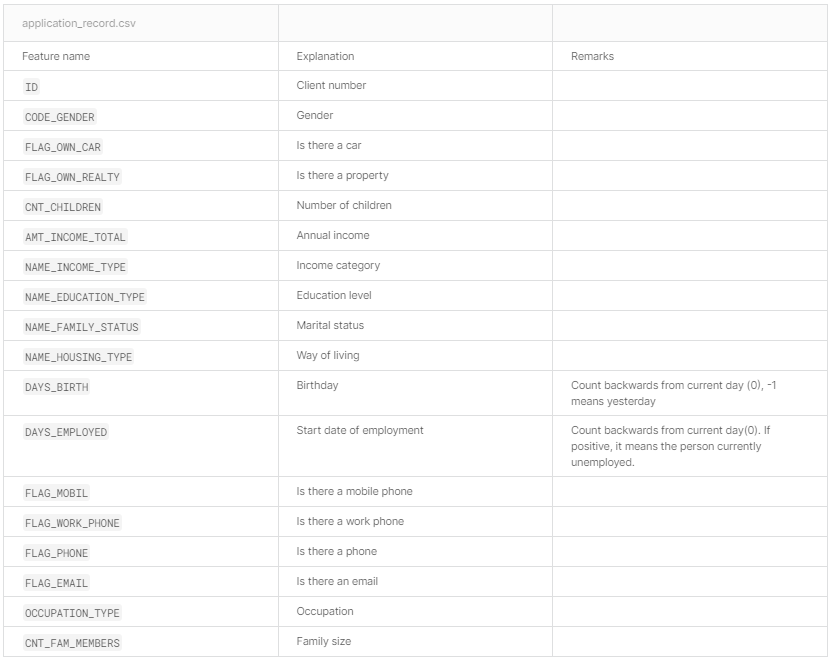

In [8]:
X.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [9]:
X.describe()

,id,cnt_children,amt_income_total,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members,months_balance
count,7.777150e+05,777715.000000,7.777150e+05,777715.000000,777715.000000,777715.0,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000
mean,5.078743e+06,0.428082,1.885348e+05,-16124.937046,57775.825016,1.0,0.231818,0.300965,0.091675,2.208837,-19.373564
std,4.180442e+04,0.745755,1.016225e+05,4104.304018,136471.735391,0.0,0.421993,0.458678,0.288567,0.907380,14.082208
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.044568e+06,0.000000,1.215000e+05,-19453.000000,-3292.000000,1.0,0.000000,0.000000,0.000000,2.000000,-29.000000
50%,5.069530e+06,0.000000,1.620000e+05,-15760.000000,-1682.000000,1.0,0.000000,0.000000,0.000000,2.000000,-17.000000
75%,5.115551e+06,1.000000,2.250000e+05,-12716.000000,-431.000000,1.0,0.000000,1.000000,0.000000,3.000000,-8.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


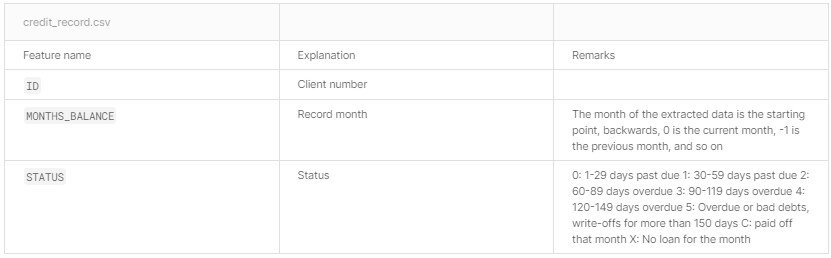

In [10]:
y.head()

,id,months_balance,status
0,5008804.0,0.0,C
1,5008804.0,-1.0,C
2,5008804.0,-2.0,C
3,5008804.0,-3.0,C
4,5008804.0,-4.0,C


In [11]:
y.describe()

,id,months_balance
count,7.777150e+05,777715.000000
mean,5.078743e+06,-19.373564
std,4.180442e+04,14.082208
min,5.008804e+06,-60.000000
25%,5.044568e+06,-29.000000
50%,5.069530e+06,-17.000000
75%,5.115551e+06,-8.000000
max,5.150487e+06,0.000000


## Tyding the data

We want to have the client's age and job seniority in years instead of days

In [12]:
def num_to_years(num):
    try:
        if num < 0:
            year = num/-365
        else:
            year = 0
    except:
        return None
    return year

In [13]:
def days_to_years(X):
    X['age'] = X['days_birth'].apply(num_to_years)
    X.drop('days_birth', axis=1)
    X['job_seniority'] = X['days_employed'].apply(num_to_years)
    X.drop('days_employed', axis=1)
    return X

In [14]:
y = y[~(y['status'].isnull())]

I want to format all status value with an inteager value, that way we can fit the values into a model

In [15]:
def status_int(s):
    if s=='C':
        return -1
    if s=='X':
        return -2
    else:
        return int(s)

y['status'] = y['status'].apply(status_int)

In [16]:
X = days_to_years(X)
X['status'] = X['status'].apply(status_int)
X = X.drop(['days_birth', 'days_employed'], axis=1)
X = X[X['job_seniority'] >=0]
X.describe()

,id,cnt_children,amt_income_total,flag_mobil,flag_work_phone,flag_phone,flag_email,cnt_fam_members,months_balance,status,age,job_seniority
count,7.777150e+05,777715.000000,7.777150e+05,777715.0,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000,777715.000000
mean,5.078743e+06,0.428082,1.885348e+05,1.0,0.231818,0.300965,0.091675,2.208837,-19.373564,-0.773726,44.177910,6.368327
std,4.180442e+04,0.745755,1.016225e+05,0.0,0.421993,0.458678,0.288567,0.907380,14.082208,0.804922,11.244669,6.684401
min,5.008804e+06,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,-2.000000,20.517808,0.000000
25%,5.044568e+06,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,2.000000,-29.000000,-1.000000,34.838356,1.180822
50%,5.069530e+06,0.000000,1.620000e+05,1.0,0.000000,0.000000,0.000000,2.000000,-17.000000,-1.000000,43.178082,4.608219
75%,5.115551e+06,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,-8.000000,0.000000,53.295890,9.019178
max,5.150487e+06,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,5.000000,68.909589,43.049315


We want to replace coded features to binary values:

In [17]:
def binary_gender(s):
    if s=='F':
        return 1
    if s=='M':
        return 0

X['code_gender'] = X['code_gender'].apply(binary_gender)

In [18]:
def binary_car(s):
    if s=='Y':
        return 1
    if s=='N':
        return 0

X['flag_own_car'] = X['flag_own_car'].apply(binary_car)
X['flag_own_realty'] = X['flag_own_realty'].apply(binary_car)

## Visualiztion

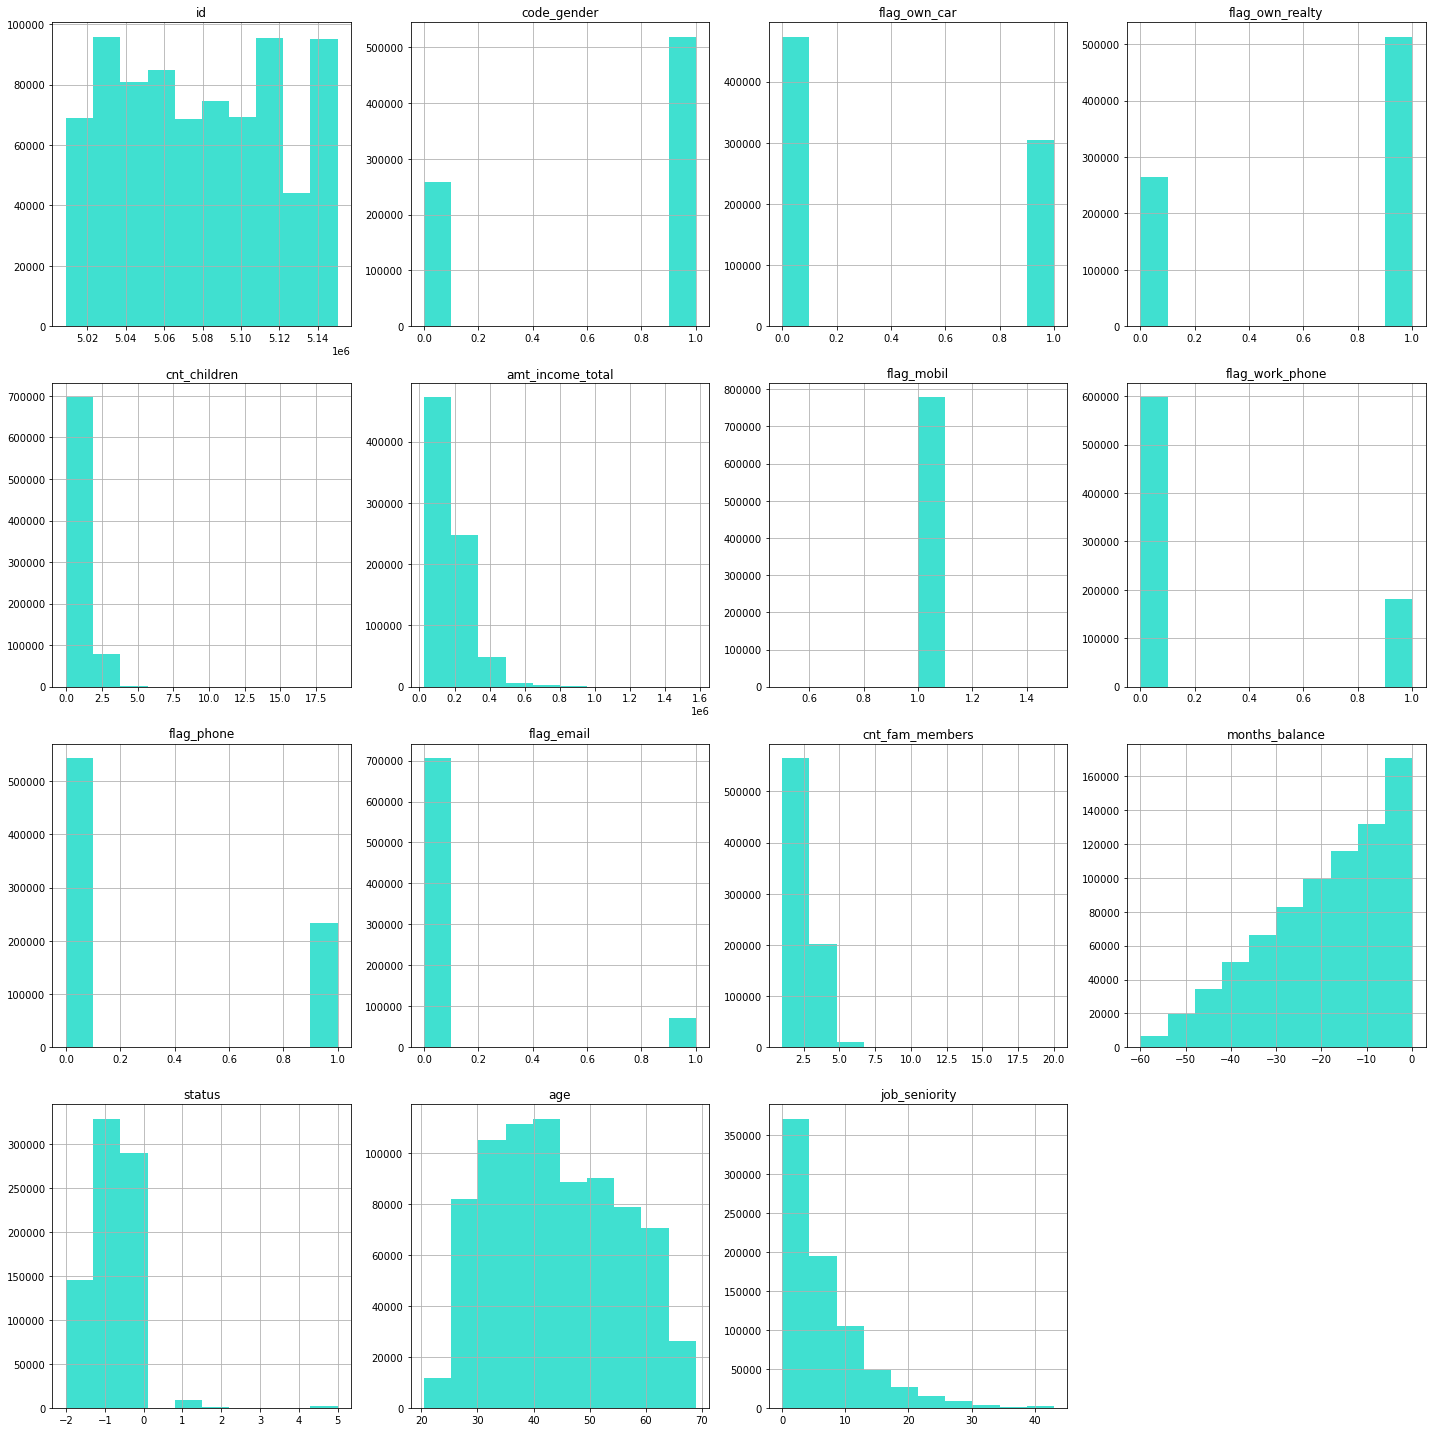

In [19]:
X.hist(figsize=(20,20), bins=10, color='turquoise')
plt.tight_layout()
plt.show()

In [20]:
#seems like all clients has a mobile phone
X.drop('flag_mobil', axis = 1, inplace = True)

In [21]:
values_count = X['name_family_status'].value_counts()

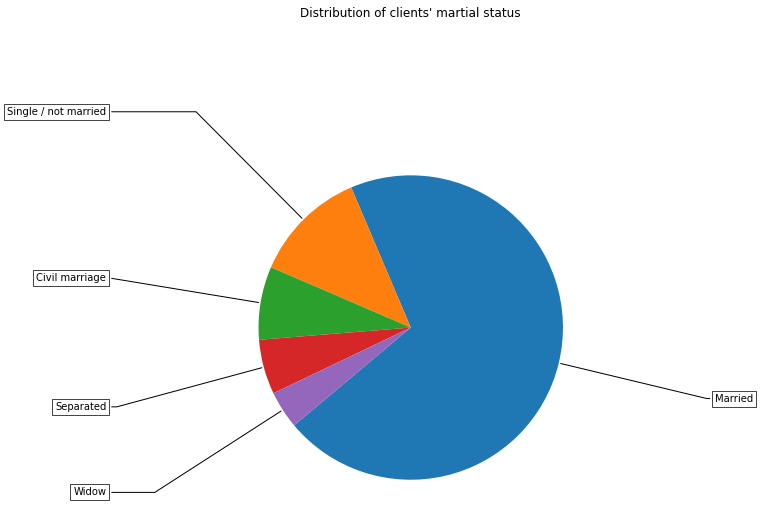

In [22]:
fig, ax = plt.subplots(figsize=(15, 7), subplot_kw=dict(aspect="equal"))

recipe = values_count.index.tolist()


data = values_count


#When you change the width to 0.5 you get a donut chart

wedges, texts = ax.pie(data, wedgeprops=dict(width=1), startangle=-140)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    z = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, z), xytext=(2*np.sign(x), 2*z),
                horizontalalignment=horizontalalignment, **kw)

plt.title("Distribution of clients' martial status", y= 1.3)

plt.show()

Most clients are married

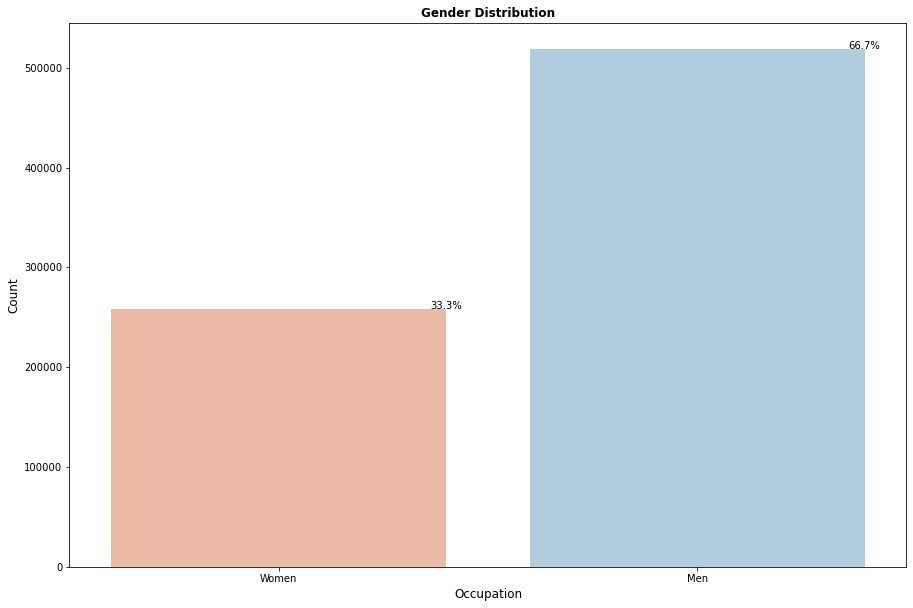

In [23]:
fig, ax = plt.subplots(figsize = (15,10))
bar = sns.countplot(x='code_gender' ,data=X, palette="RdBu")
plt.xticks([0,1], ['Women','Men' ])
total = float(len(y))
for p in bar.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x1 = p.get_x() + p.get_width()
    y1 = p.get_height()
    bar.annotate(percentage, (x1, y1),ha='center')
plt.title('Gender Distribution', weight='bold')
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Women constitute exactly 2/3 of our clients 

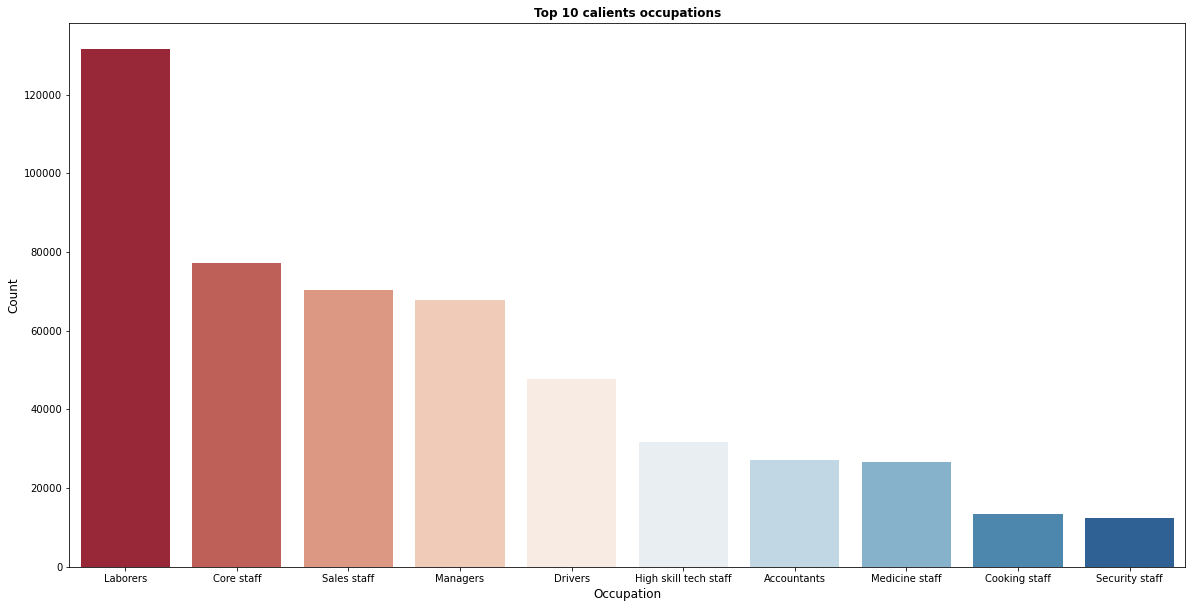

In [24]:
fig, bar = plt.subplots(figsize = (20,10))
fig
sns.countplot(x='occupation_type' ,data=X,
              order=pd.value_counts(X['occupation_type']).iloc[:10].index, palette="RdBu")
plt.title('Top 10 calients occupations', weight='bold')
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

The most common occupation among our clients is being a laborer

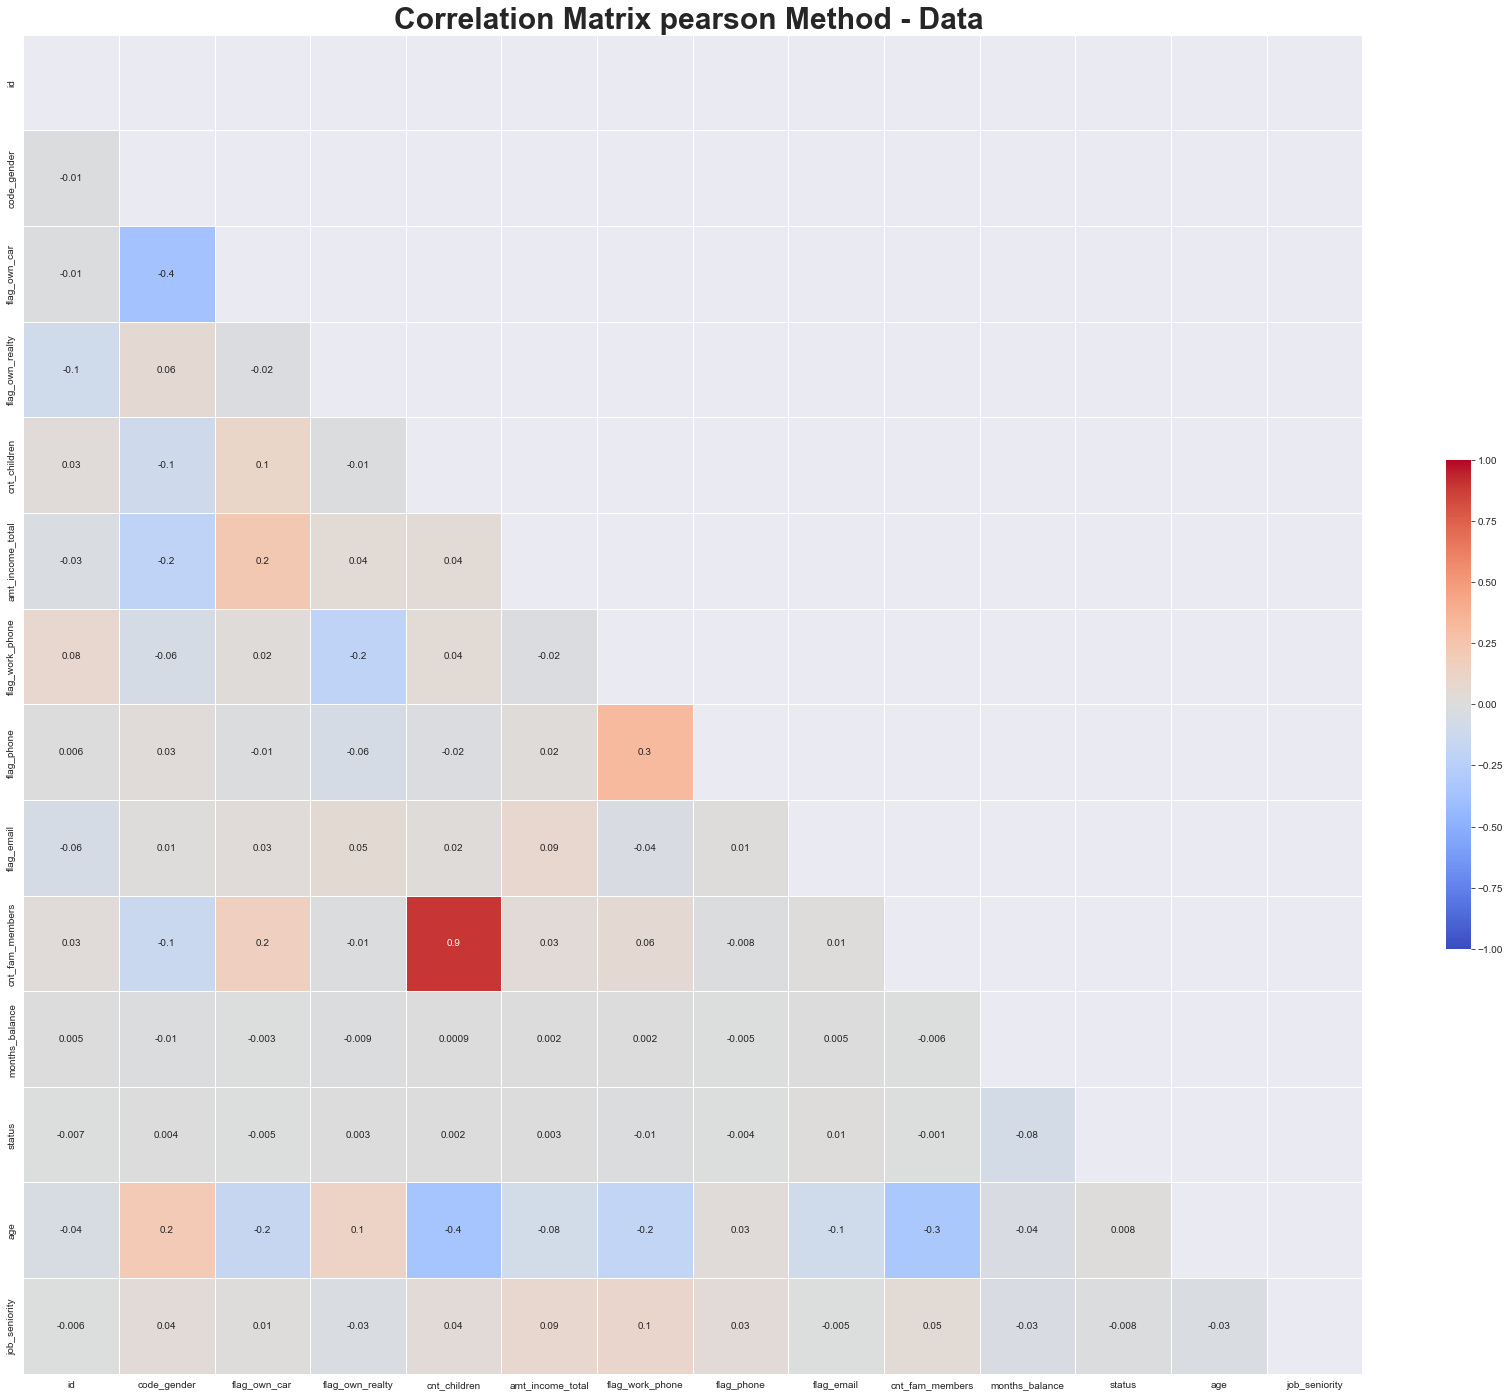

In [25]:
plt.figure(figsize=(30,30))
sns.set_style('darkgrid')
corr=X.corr(method='pearson')
mask_corr = np.triu(np.ones_like(corr, dtype=bool))
heat = sns.heatmap(corr, square=True,
            annot=True, fmt='.1g', linewidths=0.5,
            linecolor='white', cmap= 'coolwarm', mask=mask_corr,
            vmin=-1, vmax=1, cbar_kws={'shrink': 0.3},
            annot_kws={"fontsize":10},)
plt.title("Correlation Matrix pearson Method - Data ",size=30, weight='bold')
plt.show()

we can see that the correlations between the features are neutral, except for the obvious positive correlation berween family members number and number of kids.

having neutral correlations between feature means that our features are uncorrelated.

Text(0.5, 1.0, "Clients' Loan Status for Current Month")

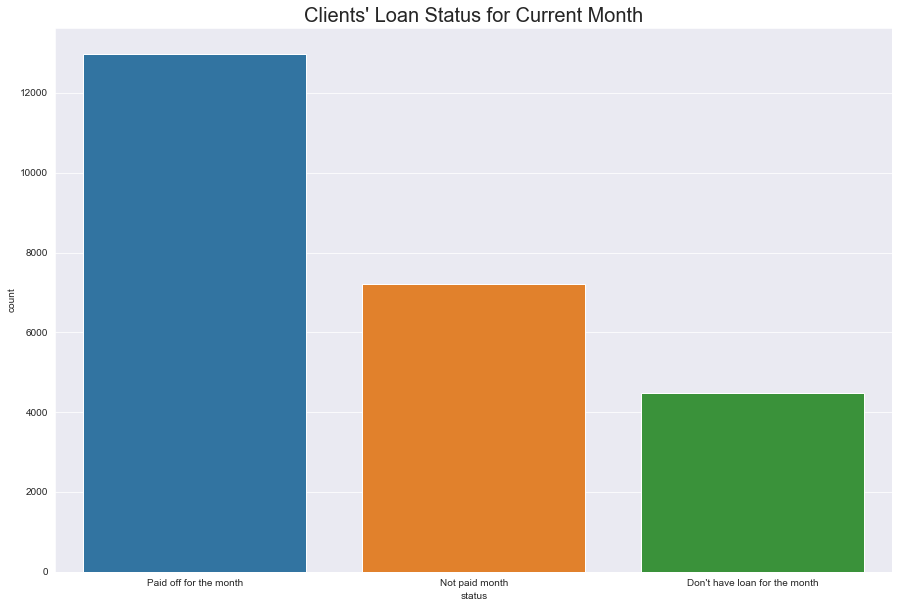

In [26]:
def is_paid(num):
    if num == -2:
        return "Don't have loan for the month"
    if num == -1:
        return 'Paid off for the month'
    else:
        return 'Not paid month'
        
paying_series = X[X.months_balance == 0]['status'].apply(is_paid)

fig, bar = plt.subplots(figsize = (15,10))
sns.countplot(x = paying_series)
plt.title("Clients' Loan Status for Current Month", size =20)

Most clients paid off the month

<BarContainer object of 5 artists>

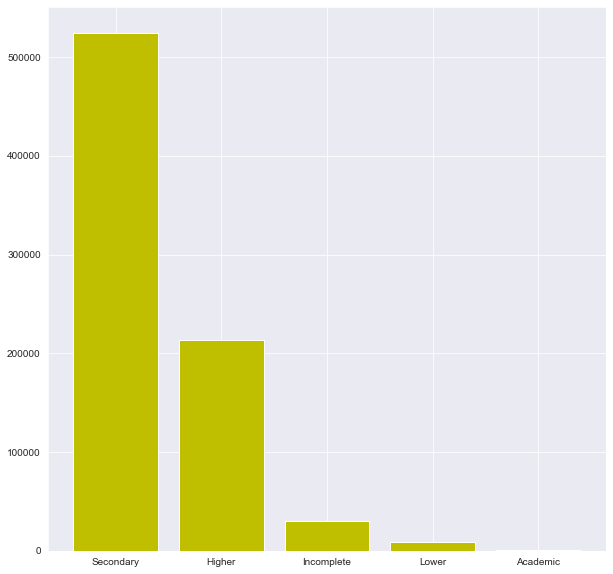

In [27]:
#let's filter all closed loans
open_loans = X[~(X['status'] < -1)]

plt.figure(figsize = (10,10))
plt.bar(x = [i.split()[0] for i in X['name_education_type'].value_counts().index.tolist()], height =  X['name_education_type'].value_counts(), color = 'y')

<AxesSubplot:title={'center':'amt_income_total'}, xlabel='name_education_type'>

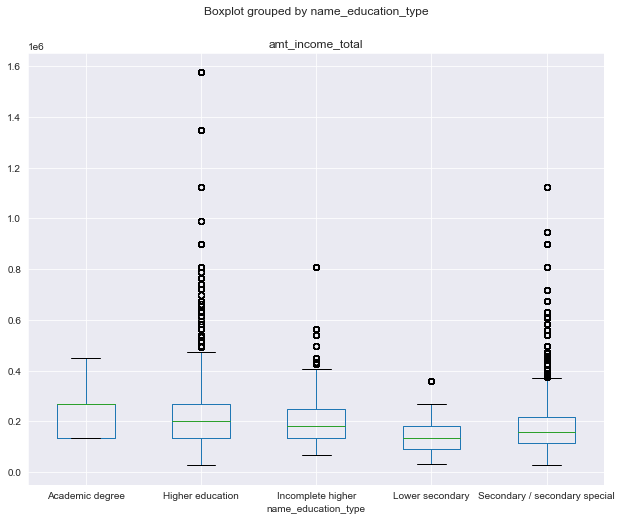

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
plt.suptitle('')
X.boxplot(column=['amt_income_total'], by='name_education_type', ax=ax)

## Preprocessing

In [29]:
#let's split X and y df, we want to keep month_recorded as a feature that will help us predict 
X.drop(columns = ['status', 'months_balance'], inplace = True)

In [30]:
#check if there are any missing values
print(X.shape)

X.isna().sum()

(777715, 17)


id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        240048
cnt_fam_members             0
age                         0
job_seniority               0
dtype: int64

we can see that the only column that has missing values is occupation_type 
I want to understand if there is a major difference between 

We can see that whether the occupation type is null or not doesn't change much about the mean status value

In [31]:
X.groupby('occupation_type').agg('mean')

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,flag_work_phone,flag_phone,flag_email,cnt_fam_members,age,job_seniority
occupation_type,,,,,,,,,,,,
Accountants,5.084152e+06,0.976086,0.386915,0.632517,0.462624,207761.509661,0.295375,0.344047,0.127356,2.239430,42.112164,7.368922
Cleaning staff,5.075761e+06,0.954908,0.111062,0.695500,0.347487,149095.947013,0.346346,0.277305,0.050794,1.934731,49.072388,7.047043
Cooking staff,5.074418e+06,0.894454,0.206023,0.628503,0.358154,144189.411896,0.240385,0.282126,0.074761,2.163760,41.491278,6.702092
Core staff,5.078680e+06,0.798669,0.378644,0.655255,0.600179,191917.622899,0.293690,0.308344,0.129980,2.372847,39.289373,8.286733
Drivers,5.076587e+06,0.059776,0.741453,0.598117,0.570808,208968.926968,0.292630,0.295818,0.090755,2.443391,41.221064,5.624932
HR staff,5.075306e+06,0.851127,0.438316,0.420522,0.402728,196705.516014,0.138197,0.298932,0.169632,1.959668,38.970302,5.746023
High skill tech staff,5.079165e+06,0.689216,0.462509,0.644076,0.508310,197953.892282,0.287931,0.390708,0.130194,2.308896,41.786829,8.998893
IT staff,5.098527e+06,0.460197,0.491281,0.507961,0.402578,223593.707354,0.108415,0.313116,0.218347,2.073541,36.432438,4.745104
Laborers,5.079365e+06,0.428685,0.431999,0.628432,0.489686,181708.198933,0.284019,0.277149,0.072021,2.282271,40.758324,7.859219


In [32]:
X[X.name_income_type =='Pensioner'].isna().sum()

id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        128060
cnt_fam_members             0
age                         0
job_seniority               0
dtype: int64

In [33]:
#we will first impute the null occupation type values by placing 'not working' whereas name_income_type is Pensioner
X.loc[X.name_income_type =='Pensioner','occupation_type'] = 'Unemployed'

In [34]:
X.isna().sum()

id                          0
code_gender                 0
flag_own_car                0
flag_own_realty             0
cnt_children                0
amt_income_total            0
name_income_type            0
name_education_type         0
name_family_status          0
name_housing_type           0
flag_work_phone             0
flag_phone                  0
flag_email                  0
occupation_type        111988
cnt_fam_members             0
age                         0
job_seniority               0
dtype: int64

In [35]:
X.loc[X['occupation_type'] == None] = 'Unknown'

we want to treat every month in the client's history as a feature

In [36]:
for x in range(-60,1):
    X["month_{0}".format(x)] = None

In [37]:
print(X.shape)
X.drop_duplicates("id", inplace = True, keep='first')
print(X.shape)

(777715, 78)
(36457, 78)


The following cell will take some time to run, as it iterate 777,715 rows

In [38]:
cur = y.iloc[0,0]
prev=0
i=-1
j=0
for index, row in y.iterrows():
    #this section was created to give us a quick access to the df
    cur = row.id
    if cur!=prev:
        prev = cur
        cur = row.id
        i +=1
        j=0
    X.iloc[i , 77-j] = int(row.status)
    j+=1
    if i%5000==0 and j==1:
        print("loaded ", round(i*100/len(X),2),"%")

loaded  0.0 %
loaded  13.71 %
loaded  27.43 %
loaded  41.14 %
loaded  54.86 %
loaded  68.57 %
loaded  82.29 %
loaded  96.0 %


In [39]:
data = [X["id"], X["month_0"]]
headers = ["id", "status"]
y = pd.concat(data, axis=1, keys=headers)

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 777701
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   36457 non-null  object
 1   code_gender          36457 non-null  object
 2   flag_own_car         36457 non-null  object
 3   flag_own_realty      36457 non-null  object
 4   cnt_children         36457 non-null  object
 5   amt_income_total     36457 non-null  object
 6   name_income_type     36457 non-null  object
 7   name_education_type  36457 non-null  object
 8   name_family_status   36457 non-null  object
 9   name_housing_type    36457 non-null  object
 10  flag_work_phone      36457 non-null  object
 11  flag_phone           36457 non-null  object
 12  flag_email           36457 non-null  object
 13  occupation_type      31273 non-null  object
 14  cnt_fam_members      36457 non-null  object
 15  age                  36457 non-null  object
 16  job

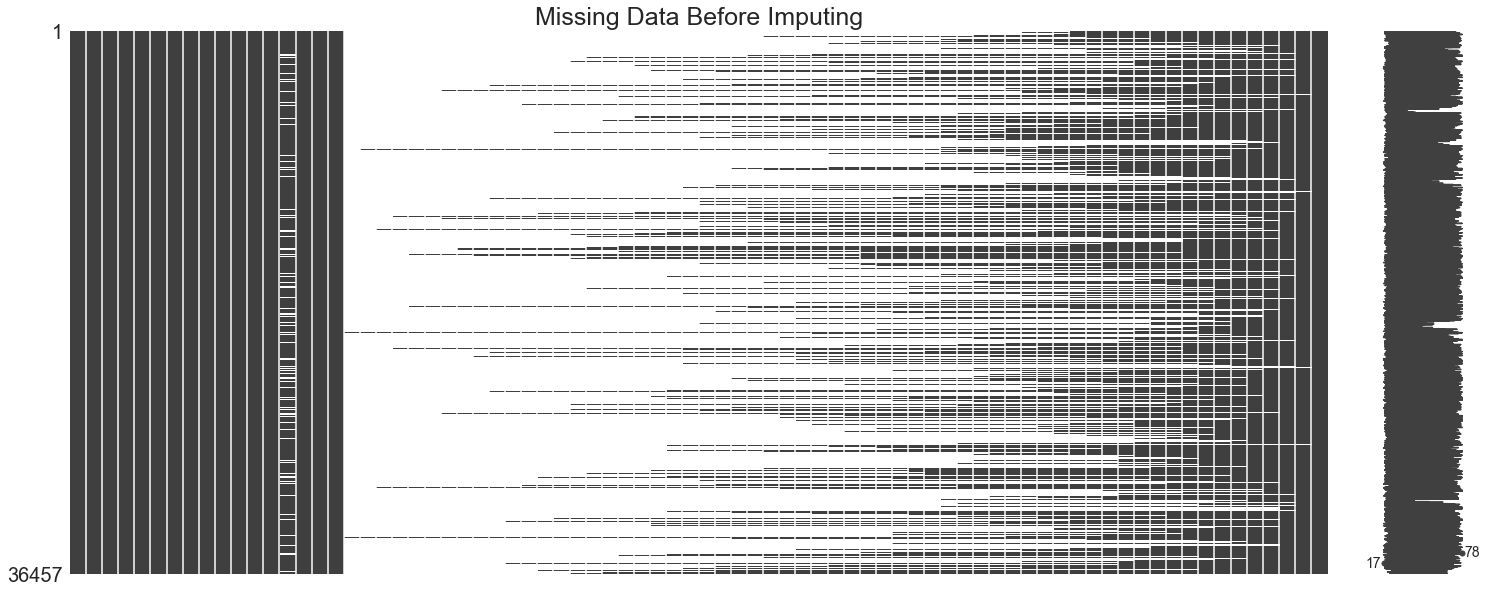

In [41]:
msno.matrix(X)
plt.title('Missing Data Before Imputing', fontsize=25)
plt.show()

In [42]:
null_lst = X.isnull().sum().divide(X.shape[0]).round(2).astype(str) + "%"
null_lst.sort_values(ascending = False)

month_-60            1.0%
month_-57           0.99%
month_-58           0.99%
month_-59           0.99%
month_-56           0.98%
                    ...  
amt_income_total     0.0%
cnt_children         0.0%
flag_own_realty      0.0%
flag_own_car         0.0%
month_0              0.0%
Length: 78, dtype: object

In [43]:
for x in range(-60,-4):
    X.drop("month_{0}".format(x), axis = 1,inplace=True)

In [44]:
y['status'] = y['status'].apply(np.int64)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y['status'], test_size=0.33, random_state=42)

In [46]:
X_train

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,flag_email,occupation_type,cnt_fam_members,age,job_seniority,month_-4,month_-3,month_-2,month_-1,month_0
139939,5029805,0,1,0,1,238500.0,Working,Higher education,Married,With parents,...,0,Drivers,3.0,31.189041,5.383562,-2,-2,-2,-2,-2
644927,5125461,1,0,0,1,112500.0,Working,Higher education,Married,House / apartment,...,1,Core staff,3.0,29.734247,0.786301,None,0,0,0,0
215918,5045658,0,0,1,0,30150.0,Pensioner,Lower secondary,Married,House / apartment,...,0,Unemployed,2.0,65.123288,0.0,-1,-1,-1,-1,-1
458316,5091153,1,1,1,0,256500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,1,Core staff,2.0,37.865753,2.934247,-2,-2,-2,-2,-2
180384,5038547,0,1,0,0,225000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,2.0,25.969863,3.131507,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358934,5067139,1,0,1,0,112500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,...,1,Unemployed,1.0,64.109589,0.0,0,0,0,0,-2
129759,5029193,1,0,1,1,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,Core staff,3.0,42.553425,22.619178,-2,-2,-2,-2,-2
232530,5047710,1,0,1,0,76500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Managers,2.0,48.717808,9.016438,-1,-1,-1,-1,-1
18371,5009886,1,0,1,0,157500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,0,Unemployed,2.0,59.273973,0.0,-1,-1,-1,-1,-1


# Categorical feature encoding

In order to minimize the number of unique values in every column we are going to 

In [47]:
def value_minimizer(df):  
    for col in df.columns:
        if "type"  in col or "name" in col:
            for val, num in zip(df[col].value_counts().index.tolist(), df[col].value_counts(normalize=True)):
                if num<0.05:
                    df.loc[df[col] == val][col]  = 'Other' 

In [48]:
value_minimizer(X_train)
value_minimizer(X_test)

C:\Users\PC\AppData\Local\Temp/ipykernel_13996/2898832462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[col] == val][col]  = 'Other'


In [49]:
for col in X_test.columns:
    if "type"  in col or "name" in col:
        print(col,'\n')
        for val, num in zip(X_train[col].value_counts().index.tolist(), X_train[col].value_counts(normalize=True)):
            print(val, num)

name_income_type 

Working 0.5149021534430525
Commercial associate 0.2323753377548514
Pensioner 0.17010562515352493
State servant 0.08237124375665275
Student 0.00024563989191844754
name_education_type 

Secondary / secondary special 0.676737902235323
Higher education 0.2730696798493409
Incomplete higher 0.038974862851060346
Lower secondary 0.010316875460574797
Academic degree 0.0009006796037009743
name_family_status 

Married 0.6884467370834357
Single / not married 0.1317448620322607
Civil marriage 0.07942356505363138
Separated 0.058175714402685666
Widow 0.04220912142798657
name_housing_type 

House / apartment 0.894620486366986
With parents 0.0475313190862196
Municipal apartment 0.030131826741996232
Rented apartment 0.01604847293867191
Office apartment 0.007246376811594203
Co-op apartment 0.004421518054532056
occupation_type 

Laborers 0.20128786072024804
Unemployed 0.1981874552826139
Core staff 0.113093250655855
Sales staff 0.10970665394705462
Managers 0.0969711423801574
Drivers 0.06

In [50]:
categorical_cols_for_encode = [col for col in X_train.columns if "type" in col or "name" in col]

In [51]:
enc = ce.OneHotEncoder(cols = categorical_cols_for_encode)
enc = enc.fit(X_train)

C:\Users\PC\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [52]:
def hot_enc_ratio(X):
    df_bin = enc.transform(X)
    return df_bin

X_train, X_test = map(hot_enc_ratio, [X_train, X_test])

In [53]:
X_train.head(10)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type_1,name_income_type_2,name_income_type_3,name_income_type_4,...,occupation_type_19,occupation_type_20,cnt_fam_members,age,job_seniority,month_-4,month_-3,month_-2,month_-1,month_0
139939,5029805,0,1,0,1,238500.0,1,0,0,0,...,0,0,3.0,31.189041,5.383562,-2,-2,-2,-2,-2
644927,5125461,1,0,0,1,112500.0,1,0,0,0,...,0,0,3.0,29.734247,0.786301,None,0,0,0,0
215918,5045658,0,0,1,0,30150.0,0,1,0,0,...,0,0,2.0,65.123288,0.0,-1,-1,-1,-1,-1
458316,5091153,1,1,1,0,256500.0,0,0,1,0,...,0,0,2.0,37.865753,2.934247,-2,-2,-2,-2,-2
180384,5038547,0,1,0,0,225000.0,1,0,0,0,...,0,0,2.0,25.969863,3.131507,-1,-1,-1,-1,-1
594208,5115581,1,1,1,0,463500.0,1,0,0,0,...,0,0,2.0,57.117808,11.205479,-2,-2,-2,-2,-2
86496,5023970,1,0,1,0,189000.0,0,1,0,0,...,0,0,2.0,63.249315,0.0,None,None,-2,-2,-2
412924,5086055,1,0,1,0,202500.0,1,0,0,0,...,0,0,2.0,43.641096,7.887671,-1,-1,-1,-1,-1
547607,5105592,1,1,1,1,135000.0,0,0,1,0,...,0,0,3.0,30.572603,2.345205,0,0,0,0,-2
645494,5125502,1,0,1,0,121500.0,0,1,0,0,...,0,0,2.0,57.290411,0.0,-1,-1,-1,-1,-1


In [54]:
def My_imputer_fit(df):
    median_vals = []
    for col in df.columns:
        median_vals.append(df[col].median())
        
    return median_vals

def My_imputer_transform(df, vals):
    for val, col in zip(vals, df.columns):
        df[col].fillna(val, inplace = True)
        

In [55]:
vals = My_imputer_fit(X_train)

My_imputer_transform(X_train,vals)
My_imputer_transform(X_test,vals)

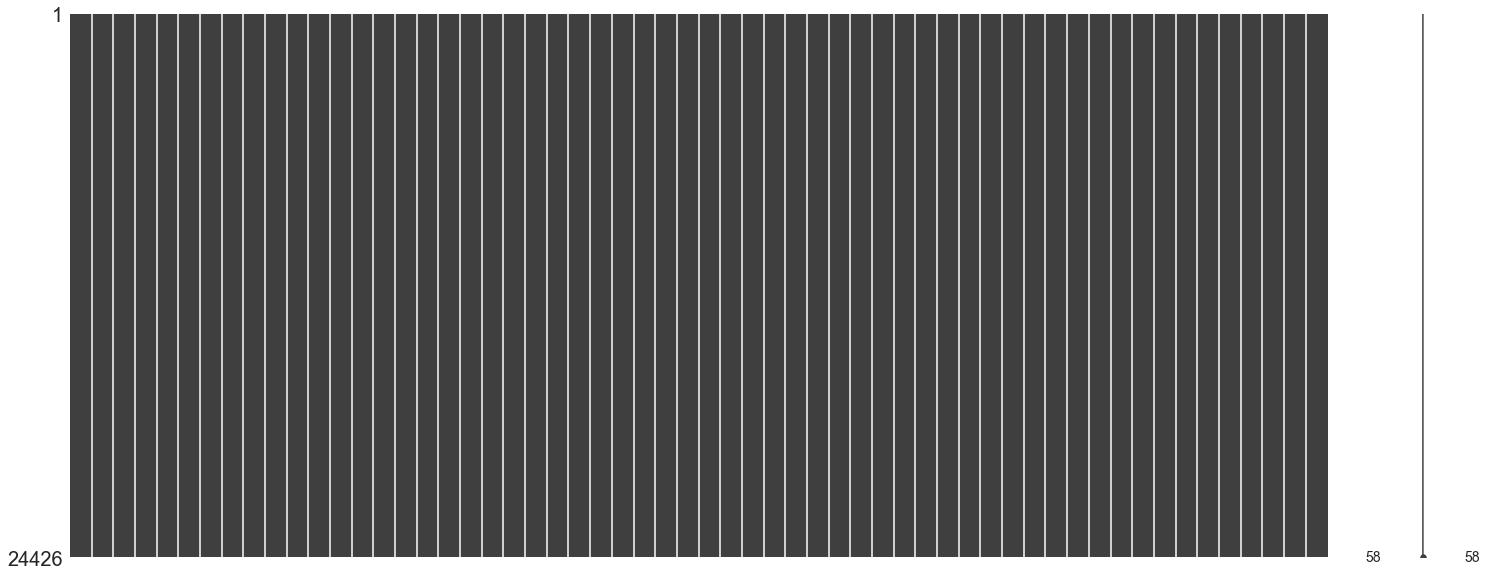

In [56]:
msno.matrix(X_train)
plt.show()

In [57]:
for col in X_train.columns:
    if X_train[col].dtypes == np.float64:
        X_train[col] = X_train[col].apply(np.int64)

## Modelling

In [59]:
classifiers = [
    ('LGR', LogisticRegression(max_iter= 200)),
    ('KNN', KNeighborsClassifier(algorithm='brute')),
    ('RFC', RandomForestClassifier()),
    ('MLP', MLPClassifier())
    ]

In [60]:
#Let's fit the models to the train data one by one:

for model_name, model in tqdm(classifiers):
    model.fit(X_train, y_train)

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


In [61]:
def model_compare(X, y, classifiers, name= ""):
    
    res = pd.DataFrame()
    
    kfold = model_selection.KFold(n_splits=5)
    
    for model_name, model in classifiers:
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        msg = "{} cross validation accuracy score: {:.3f} +/- {:.3f} (STD) \n Min Score: {:.3f}, Max Score: {:.3f}".format(model_name, cv_results.mean(), cv_results.std(), cv_results.min(), cv_results.max())
        print(msg)
        cv_results = pd.Series(cv_results)
        res[model_name] = cv_results
    res["type"] = name
    return res

In [62]:
print('Train Scores')
res_naive_train = model_compare(X_train, y_train, classifiers, name = "Train")
print('Test Scores')
res_naive_test = model_compare(X_test, y_test, classifiers, name = "Test")

Train Scores


C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LGR cross validation accuracy score: 0.491 +/- 0.009 (STD) 
 Min Score: 0.478, Max Score: 0.503
KNN cross validation accuracy score: 0.507 +/- 0.006 (STD) 
 Min Score: 0.499, Max Score: 0.517
RFC cross validation accuracy score: 0.996 +/- 0.000 (STD) 
 Min Score: 0.995, Max Score: 0.997
MLP cross validation accuracy score: 0.403 +/- 0.107 (STD) 
 Min Score: 0.219, Max Score: 0.490
Test Scores


C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LGR cross validation accuracy score: 0.495 +/- 0.007 (STD) 
 Min Score: 0.482, Max Score: 0.501
KNN cross validation accuracy score: 0.479 +/- 0.009 (STD) 
 Min Score: 0.464, Max Score: 0.490
RFC cross validation accuracy score: 0.994 +/- 0.002 (STD) 
 Min Score: 0.991, Max Score: 0.997
MLP cross validation accuracy score: 0.300 +/- 0.101 (STD) 
 Min Score: 0.216, Max Score: 0.498


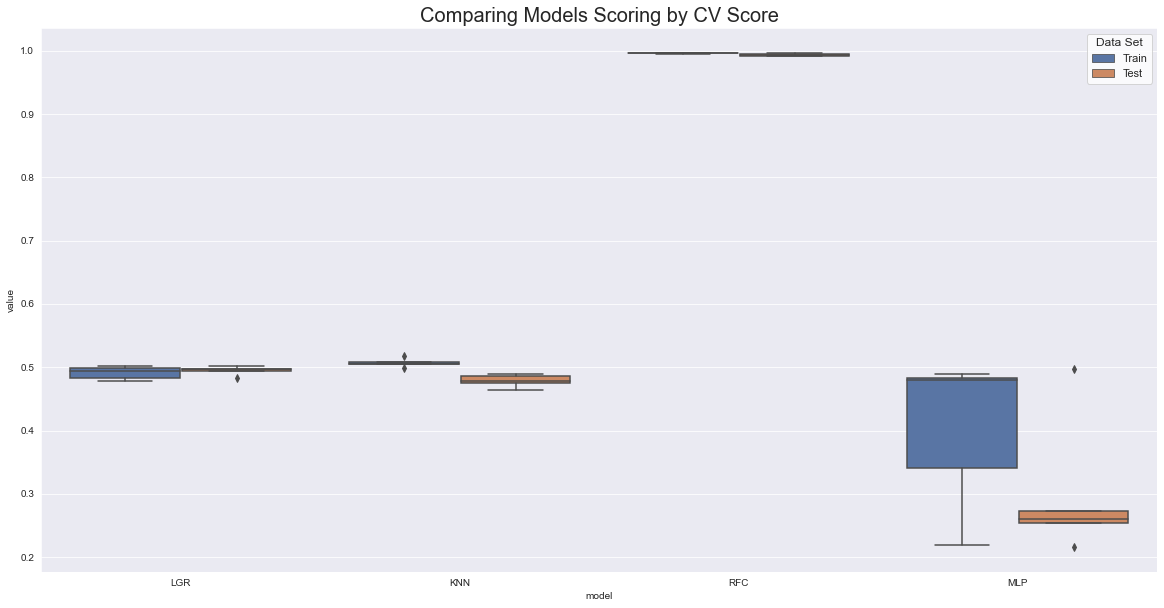

In [63]:
def plot_compare(lst):
    con = pd.concat(lst)
    value_vars = con.columns.to_list()
    value_vars.pop()
    con = pd.melt(con, id_vars=['type'], value_vars=value_vars, var_name='model')
    plt.plot
    fig, bar = plt.subplots(figsize = (20,10))
    sns.set_theme(style="whitegrid")
    box = sns.boxplot(x='model', y='value', data=con, hue='type')
    plt.title('Comparing Models Scoring by CV Score', fontdict = {'size': 20})
    plt.legend(title='Data Set')
    plt.show
plot_compare([res_naive_train, res_naive_test])


even with the default hyperparameters Random Forest is BY FAR the most accurate model with 99% accuracy score on test data.

In [64]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

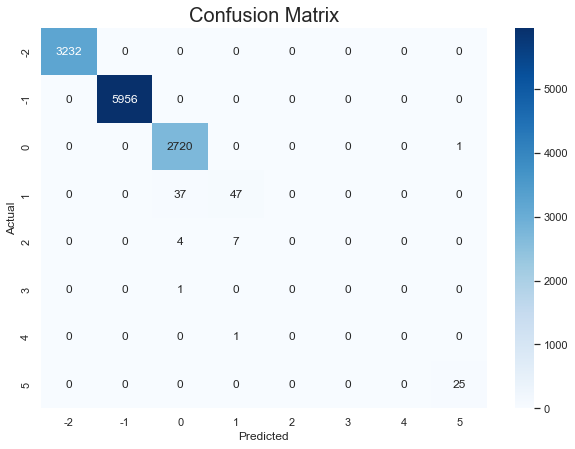

In [65]:
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confusion, index = range(-2,6),
                  columns = range(-2,6))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontdict = {'size': 20})
plt.show()

In [66]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Coclusion

This project was actually shorter than I expected, due to the fact I reached high accuracy score over a relatively short period of time. 
The reasons for the high accuracy score may be one of the following:

-Similar data for each label - Maybe the clients in each label have very similar data and by that it was "easy" for the algorithm to classify the observations in our test data
-Good model selection - The random forest classifier reduces overfitting in decision trees and helps to improve the accuracy (as we saw in the box plot graph), it is also flexible to both classification problems.
-Good feature selection - I created some new feature such as historical feature about the  
-Unbalanced data - We can see that most labels are -2,-1 and 0. So even if we have many labels, most clients belong to each one of those 3 classes.
